In [1]:
# Dependencies and Setup
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json

import numpy as np
from numpy import mean
from scipy import stats
import pandas as pd

import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

**Design a query to retrieve the last 12 months of precipitation data and plot the results**

In [8]:
# Calculate the date 1 year ago from the last data point in the database
# Last data point
last_date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date_str = last_date_query[0]
last_date = dt.datetime.strptime(last_date_str, '%Y-%m-%d').date()

# 1 year ago from the last data point
yr_ago_date = last_date - dt.timedelta(days=365)
yr_ago_date_str = yr_ago_date.strftime('%Y-%m-%d')

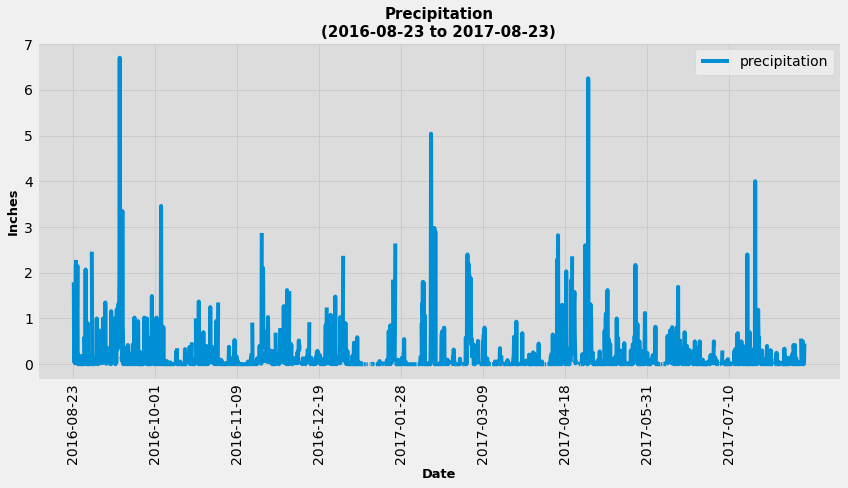

In [9]:
# Perform a query to retrieve the data and precipitation scores
prcp_12m = session.query(Measurement.date, Measurement.prcp)\
                    .filter(Measurement.date <= last_date_str)\
                    .filter(Measurement.date >= yr_ago_date_str).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_12m_df = pd.DataFrame(prcp_12m, columns=['date', 'precipitation']).set_index('date')

# Sort the dataframe by date
prcp_12m_df_sorted =  prcp_12m_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
pd_bar_prcp_12m = prcp_12m_df_sorted.plot(kind='line', rot=90, figsize=(12,7), grid=True, use_index=False)

# Set xticks for plotting
data_date = prcp_12m_df_sorted.index
list_date_index = [*range(len(data_date))]
date_pos = []
index = 0
interval = 250

while index < max(list_date_index):
    date_pos.append(index)
    index += interval

positions = np.arange(min(list_date_index), max(list_date_index)+1, 250)
labels = [data_date[d] for d in date_pos]
plt.xticks(positions, labels)

# Set x/y label, title
plt.title(f'Precipitation\n({yr_ago_date_str} to {last_date_str})', fontweight = 'bold', size=15)
plt.xlabel('Date', fontweight = 'bold', size=13)
plt.ylabel('Inches', fontweight = 'bold', size=13)
pd_bar_prcp_12m.set_facecolor('gainsboro')
plt.tight_layout()

# Save bar graph to Images folder
pd_bar_prcp_12m.figure.savefig('Images/pd_bar_prcp_12m.png')

# Present the bar chart
plt.show()

# To close pyplot
plt.close()

In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_st_summary = prcp_12m_df.describe()
prcp_st_summary

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
# Design a query to show how many stations are available in this dataset?
no_station = session.query(Measurement.station).distinct().count()
print(f'There are {no_station} stations available in this dataset')

There are 9 stations available in this dataset


In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
most_active = session.query(Measurement.station, Station.name, func.count(Measurement.station))\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc())\
                                .first()

print(f'The most active station is station id {most_active[0]}: {most_active[1]}')

The most active station is station id USC00519281: WAIKIKI 717.2, HI US


In [13]:
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, Station.name, func.count(Measurement.station))\
                                .filter(Measurement.station == Station.station)\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc())\
                                .all()

# Save the query results as a Pandas DataFrame and set the index to the date column
active_station_df = pd.DataFrame(active_station, columns=['station_id', 'name', 'no. of data'])


active_station_df

,station_id,name,no. of data
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
act_stn_summary = session.query(Measurement.station, Station.name, func.min(Measurement.tobs), 
                                func.max(Measurement.tobs), func.avg(Measurement.tobs))\
                                .filter(Measurement.station == Station.station)\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc())\
                                .filter(Measurement.station == most_active[0])

# Save the query results as a Pandas DataFrame and set the index to the date column
act_stn_summary_df = pd.DataFrame(act_stn_summary, columns=['station_id', 'name', 'min temp', 'max temp', 'avg temp'])

act_stn_summary_df

,station_id,name,min temp,max temp,avg temp
0,USC00519281,"WAIHEE 837.5, HI US",54.0,85.0,71.663781


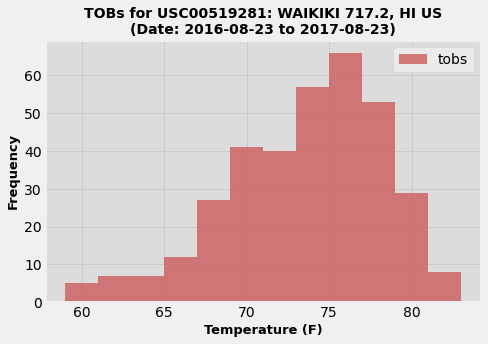

In [15]:
# Query the last 12 months of temperature observation data for this station
st_12m = session.query(Measurement.tobs)\
                    .filter(Measurement.date <= last_date_str)\
                    .filter(Measurement.date >= yr_ago_date_str)\
                    .filter(Measurement.station == most_active[0])\
                    .all()

# Save the query results as a Pandas DataFrame and set the index to the date column
st_12m_df = pd.DataFrame(st_12m, columns=['tobs'])

# Plot the results as a histogram
st_12m_df_plot = st_12m_df.plot.hist(bins=12, figsize=(7,5), color='indianred', alpha=0.8)

# Set x/y label, title
plt.title(f'TOBs for {most_active[0]}: {most_active[1]}\n(Date: {yr_ago_date_str} to {last_date_str})', fontweight = 'bold', size=14)
plt.xlabel('Temperature (F)', fontweight = 'bold', size=13)
plt.ylabel('Frequency',fontweight = 'bold', size=13)
st_12m_df_plot.set_facecolor('gainsboro')
plt.tight_layout()

# Save bar graph to Images folder
pd_bar_prcp_12m.figure.savefig('Images/hist_stUSC00519281.png')

# Present the bar chart
plt.show()

# To close pyplot
plt.close()

## Bonus Challenge Assignment

### Temperature Analysis I

In [16]:
# Temperature in June
jun_str = '06'
jun_temp_data = session.query(Measurement.tobs)\
                    .filter(func.strftime('%m', Measurement.date) == jun_str)\
                    .all()

# Filter out null values from lists
jun_temp = []
for jt in jun_temp_data:
    if jt.tobs != None:
        jun_temp.append(jt.tobs)

In [17]:
# Temperature in December
dec_str = '12'
dec_temp_data = session.query(Measurement.tobs)\
            .filter(func.strftime('%m', Measurement.date) == dec_str)\
            .all()

# Filter out null values from lists
dec_temp = []
for dt in dec_temp_data:
    if dt.tobs != None:
        dec_temp.append(dt.tobs)       

In [18]:
# Unpaired t-test calculation > different
t_test = stats.ttest_ind(jun_temp, dec_temp)

temp_summary = {
    'Avg Temp Jun': round(mean(jun_temp), 4),
    'Avg Temp Dec': round(mean(dec_temp), 4),
    'Ttest-Statistic': t_test[0],
    'Ttest_pvalue': round(t_test[1], 4)
}

print(json.dumps(temp_summary, indent=4))

{
    "Avg Temp Jun": 74.9441,
    "Avg Temp Dec": 71.0415,
    "Ttest-Statistic": 31.60372399000329,
    "Ttest_pvalue": 0.0
}


### Temperature Analysis II

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [20]:
# The previous year's data (Trip date: 2017-12-28 to 2018-01-03)
trip_strt_date = '2016-12-28'
trip_end_date = '2017-01-03'

# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
trip_results = calc_temps(trip_strt_date, trip_end_date)

trip_tmin = trip_results[0][0]
trip_tmax = trip_results[0][2]
trip_avg = trip_results[0][1]

trip_summary = {
    'Min Temp': trip_tmin,
    'Max Temp': trip_tmax,
    'Avg Temp': round(trip_avg,2)
}

print(json.dumps(trip_summary, indent=4))

{
    "Min Temp": 62.0,
    "Max Temp": 77.0,
    "Avg Temp": 69.81
}


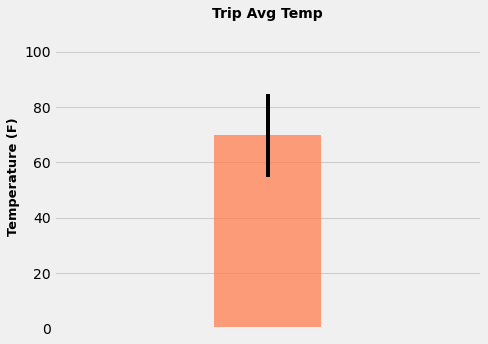

In [21]:
# Plot the results from your previous query as a bar chart.
fig, ax = plt.subplots(figsize=(7, 5))

# Use the average temperature for the y value
y_value = trip_results[0][1]

# The peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = trip_tmax - trip_tmin

# Plot the result
x_axis = np.arange(len(trip_results[0]))
plt.xticks([])
plt.bar(x_axis[0], y_value, yerr=yerr, alpha=0.75, color='coral', width=0.5)
plt.ylabel('Temperature (F)', fontweight='bold', fontsize=13)
plt.xlim(-1, 1)
plt.ylim(0,110)

# Use "Trip Avg Temp" as your Title
plt.title('Trip Avg Temp', fontweight='bold', fontsize=14)

# Save the figure and show
plt.tight_layout()
plt.savefig('Images/bar_plot_with_error_bars.png')
plt.show()

### Daily Rainfall Average

In [22]:
# Total amount of rainfall per weather station last year matching trip date, order by precipitation amount
trip_prcp = session.query(Measurement.station, Station.name,
                          Station.latitude, Station.longitude, 
                          Station.elevation, func.sum(Measurement.prcp))\
                            .filter(Measurement.date <= trip_end_date)\
                            .filter(Measurement.date >= trip_strt_date)\
                            .group_by(Measurement.station)\
                            .order_by(func.sum(Measurement.prcp).desc())\
                            .filter(Measurement.station == Station.station).all()

# Store the result into data frame
trip_prcp_df = pd.DataFrame(trip_prcp, columns=['Station ID', 
                                                'Name', 
                                                'Latitude', 
                                                'Longitude', 
                                                'Elevation', 
                                                'Total Rainfall'])

# Display data
trip_prcp_df

,Station ID,Name,Latitude,Longitude,Elevation,Total Rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.47
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.39
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.23
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.19
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.19
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.18
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


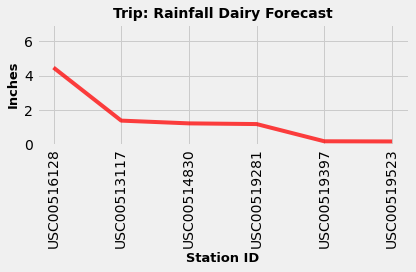

In [23]:
# Plot rainfall data
rainfall_df = trip_prcp_df.loc[trip_prcp_df['Total Rainfall'] != None]
x = rainfall_df['Station ID']
y = rainfall_df['Total Rainfall']
plt.plot(x, y, 'red', alpha=0.75)
plt.ylim(0, 7)
plt.xticks(rotation=90)
plt.xlabel('Station ID', fontweight='bold', fontsize=13)
plt.ylabel('Inches', fontweight='bold', fontsize=13)
plt.title('Trip: Rainfall Dairy Forecast', fontweight='bold', fontsize=14)
plt.rcParams["figure.figsize"] = (7,5)

# Save the figure and show
plt.tight_layout()
plt.savefig('Images/trip_plot_rainfall.png')
plt.show()

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip: 2017-12-23 to 2018-01-03
start_date = '2017-12-28'
end_date = '2018-01-03'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start_date, end_date)

# Stip off the year and save a list of %m-%d strings
trip_forcast_dates = [trip_dates[d].strftime("%m-%d")  for d in range(len(trip_dates))]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for dm in range(len(trip_forcast_dates)):
    trip_result = daily_normals(trip_forcast_dates[dm])
    normals.append(trip_result[0])

# Temperature list for dataframe
trip_tmin = [normals[tm][0] for tm in range(len(normals))]
trip_tmax = [normals[tM][2] for tM in range(len(normals))]
trip_tavg = [normals[ta][1] for ta in range(len(normals))]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_temp_df = pd.DataFrame({
    'Date': trip_dates,
    'TMin': trip_tmin,
    'TAvg': trip_tavg,
    'TMax': trip_tmax
    
}).set_index('Date')

trip_temp_df

,TMin,TAvg,TMax
Date,,,
2017-12-28,62.0,70.520833,77.0
2017-12-29,57.0,70.291667,78.0
2017-12-30,63.0,69.863636,76.0
2017-12-31,56.0,68.279070,77.0
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0


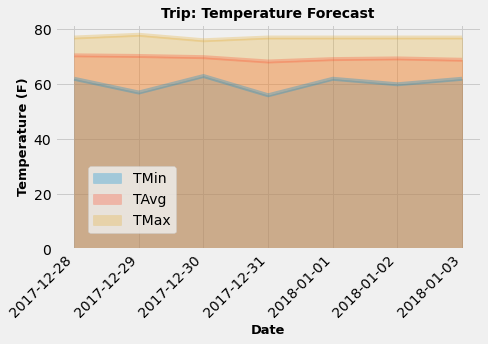

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
trip_temp_plot = trip_temp_df.plot(kind='area', stacked=False, rot=45, use_index=False, alpha=0.3, figsize=(7,5))
positions = list(np.arange(len(trip_dates)))
labels = trip_dates.strftime("%Y-%m-%d")
plt.xticks(positions, labels)
plt.xlabel('Date', fontweight='bold', fontsize=13)
plt.ylabel('Temperature (F)', fontweight='bold', fontsize=13)
plt.title('Trip: Temperature Forecast', fontweight='bold', fontsize=14)
plt.legend(loc='best', bbox_to_anchor=(-0.2, -0.1, 0.5, 0.5))

# Save the figure and show
plt.tight_layout()
plt.savefig('Images/trip_plot.png')
plt.show()